# Multiple Arms

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Examining the State and Action Spaces


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from collections import deque
import random
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
BUFFER_SIZE=100000
BATCH_SIZE=128
GAMMA=0.99
TAU=0.001

LRactor=5e-4
LRcritic=5e-4
UPDATE_EVERY=1


cpu


### Actor Model

In [6]:
import torch.nn
class Actor(nn.Module):
    def __init__(self,state_size=33, action_size=4,seed=0):
        super(Actor, self).__init__()
        self.state_size=state_size
        self.action_size=action_size
        self.fc1=nn.Linear(self.state_size,128)
        self.bn1 = nn.BatchNorm1d(128)

        self.fc2=nn.Linear(128,128)
        self.fc3=nn.Linear(128,self.action_size)
        self.seed=torch.manual_seed(seed)
    def forward(self, x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return F.tanh(x)
          

### Critic Model

In [7]:
class Critic(nn.Module):
    def __init__(self, state_size=33,action_size=4,seed=0):
        super(Critic, self).__init__()
        self.state_size=state_size
        self.action_size=action_size
        self.fc1=nn.Linear(self.state_size,128)
        self.bn1 = nn.BatchNorm1d(128)

        self.fc2=nn.Linear(128+self.action_size,128)
        self.fc3=nn.Linear(128,1)
        self.seed=torch.manual_seed(seed)
    def forward(self,state,action):
        x=F.relu(self.fc1(state))
        action=action.view(BATCH_SIZE,-1)
        x=torch.cat([x,action],1)
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x




### Memory Class

In [8]:
class Memory:
    def __init__(self,seed=0):
        self.memory=deque(maxlen=BUFFER_SIZE)
        self.seed=torch.manual_seed(seed)
    def add(self,state, action, reward,next_state,done):
        self.memory.append([state,action,reward,next_state,done])
    def sample(self,batch_size=BATCH_SIZE):
        experiences=random.sample(self.memory, k=batch_size)
        states=[]
        actions=[]
        rewards=[]
        next_states=[]
        dones=[]
        for i in experiences:
            states.append(i[0])
            actions.append(i[1])
            rewards.append(i[2])
            next_states.append(i[3])
            dones.append(i[4])
        return states, actions,rewards,next_states, dones
    def __len__(self):
        return len(self.memory)

### Ornstein–Uhlenbeck Noise 

In [9]:
import copy
class OUNoise(object):
    def __init__(self, action_space=4, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000,seed=0):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = 4
        self.low          = -1
        self.high         = 1
        self.seed=torch.manual_seed(seed)
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

### Deep Deterministic Policy gradient algorithm

In [10]:
class DDPG:
    def __init__(self,state_size=33,action_size=4,seed=0):
        self.state_size=state_size
        self.action_size=action_size
        
        self.actorlocal=Actor(state_size,action_size).to(device)
        self.actortarget=Actor(state_size,action_size).to(device)
        
        self.criticlocal=Critic(state_size,action_size).to(device)
        self.critictarget=Critic(state_size,action_size).to(device)
        
        self.memory=Memory()
        
        self.noise=OUNoise(action_space=action_size)
        
        self.t_step=0
        self.optimizeractor=optim.Adam(self.actorlocal.parameters(),lr=LRactor)
        self.optimizercritic=optim.Adam(self.criticlocal.parameters(),lr=LRcritic)
        self.critic_criterion  = nn.MSELoss()
        self.seed=torch.manual_seed(seed)
        self.hard_copy_weights(self.actortarget, self.actorlocal)
        self.hard_copy_weights(self.critictarget, self.criticlocal)


    
    def hard_copy_weights(self, target, source):
        """ copy weights from source to target network (part of initialization)"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)
    
    def step(self,state, action,reward,next_state, done):
        #self.memory.add(state, action,reward,next_state,done)
        self.t_step=(self.t_step+1)%UPDATE_EVERY
        if(self.t_step==0):
            if(len(self.memory)>=BATCH_SIZE):
                experiences=self.memory.sample()
                self.learn(experiences)
    
    def act(self,state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action = self.actorlocal(state)
        action = action.cpu().detach().numpy()
        #return np.clip(action, -1, 1)
        return action
        
        
    
    def learn(self,experiences):
        states, actions, rewards, next_states, dones = experiences
        states = torch.FloatTensor(states).to(device)
        actions = torch.FloatTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones=torch.FloatTensor(dones).to(device)
    
        # Critic loss        
        Qvals = self.criticlocal(states, actions)
        next_actions = self.actortarget(next_states)
        next_Q = self.critictarget(next_states, next_actions.detach())
        rewards=rewards.view(BATCH_SIZE,1)
        dones=dones.view(BATCH_SIZE,1)
        Qprime = rewards + (GAMMA * next_Q *(1-dones))
        #print(Qprime)
        #print(Qvals)
        critic_loss = self.critic_criterion(Qvals, Qprime.detach())

        # Actor loss
        policy_loss = -self.critictarget(states, self.actorlocal(states)).mean()
        
        # update networks
        self.optimizeractor.zero_grad()
        policy_loss.backward()
        self.optimizeractor.step()

        self.optimizercritic.zero_grad()
        critic_loss.backward() 
        self.optimizercritic.step()

        # update target networks 
        for target_param, param in zip(self.actortarget.parameters(), self.actorlocal.parameters()):
            target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))
       
        for target_param, param in zip(self.critictarget.parameters(), self.criticlocal.parameters()):
            target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))       

## Training

In [12]:
def reset(env):
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    return env_info.vector_observations

def step(env,actions):
    env_info = env.step(actions)[brain_name]       
    next_states = env_info.vector_observations  
    rewards = env_info.rewards                 
    dones = env_info.local_done               
    return next_states,rewards,dones

from matplotlib import pyplot as plt

num_episodes=1000
agent=DDPG()
noise=OUNoise()
scores_lst=[]
scores_window=deque(maxlen=100)
for i_episode in range(1,num_episodes+1):    
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)
    
    t_step=0
    agt_ctr=-1
    while True:
        actions=[noise.get_action(agent.act(states[j]),t_step) for j in range(20)]
        env_info = env.step(actions)[brain_name]           
        next_states = env_info.vector_observations         
        rewards = env_info.rewards                         
        dones = env_info.local_done
        if(t_step%2==0):
            agt_ctr=(agt_ctr+1)%20
            agent.step(states[agt_ctr],actions[agt_ctr],rewards[agt_ctr],next_states[agt_ctr],dones[agt_ctr])
        for j in range(20):
            if(j!=agt_ctr):
                agent.memory.add(states[j],actions[j], rewards[j],next_states[j],dones[j])        
        scores += env_info.rewards
        scores_lst.append(scores)
        scores_window.append(scores)
        states = next_states                               
        t_step+=1
        if np.any(dones):                                  
            break
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    scores_lst.append(scores)
    scores_window.append(scores)
    if np.mean(scores_window)>30.0:
        torch.save(agent.actorlocal.state_dict(), 'actor_checkpoint_multiple.pth')
        torch.save(agent.criticlocal.state_dict(),'critic_checkpoint_multiple.pth')
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        break

Episode 81	Average Score: 30.02
Environment solved in 81 episodes!	Average Score: 30.02


## Visualization of training

Text(0.5,0,'Episode #')

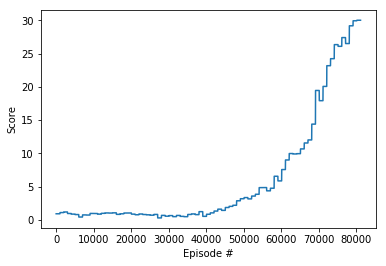

In [27]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(np.mean(scores_lst,axis=1))), np.mean(scores_lst,axis=1))
plt.ylabel('Score')
plt.xlabel('Episode #')


## Testing 

In [32]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions=[agent.act(states[j]) for j in range(20)]
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 30.34699932169169
